# Calculate network routes between origins and destinations

IGNORING FREEWAYS + USING IGRAPH (brings simulation time down from ~10 hours to ~1.5 hours)

In [1]:
import igraph as ig
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from scipy.stats import ttest_ind

simulate_all_trips = True

## Load network and ODs

In [2]:
# load the origin-destination node pairs
od_dir = pd.read_csv('data/od-directed-no-fwy.csv')
od_undir = pd.read_csv('data/od-undirected-no-fwy.csv')
print(len(od_dir))
print(len(od_undir))

1594
1594


In [3]:
%%time
# load the networks
G_dir = ox.load_graphml('sf-directed-no-fwy.graphml', folder='data')
G_undir = ox.load_graphml('sf-undirected-no-fwy.graphml', folder='data')

Wall time: 3.21 s


In [4]:
print(nx.is_strongly_connected(G_dir))
print(nx.is_strongly_connected(G_undir))

False
False


## How many trips to simulate

In [5]:
# there are 1,133,333 daily trips that being/end in SF
if simulate_all_trips:
    total_daily_trips = 1133333
    multiplier = total_daily_trips / len(od_dir)
    multiplier = math.ceil(multiplier)
else:
    multiplier = 1
multiplier

711

In [6]:
od_dir = pd.concat([od_dir]*multiplier, ignore_index=True)
len(od_dir)

1133334

In [7]:
od_undir = pd.concat([od_undir]*multiplier, ignore_index=True)
len(od_dir)

1133334

## Convert networkx graphs to igraph

In [8]:
weight = 'length'

G_dir = nx.relabel.convert_node_labels_to_integers(G_dir)
G_dir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_dir.nodes().items()}

G_undir = nx.relabel.convert_node_labels_to_integers(G_undir)
G_undir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_undir.nodes().items()}

In [9]:
%%time
# convert directed networkx graph to igraph
G_dir_ig = ig.Graph(directed=True)
G_dir_ig.add_vertices(list(G_dir.nodes()))
G_dir_ig.add_edges(list(G_dir.edges()))
G_dir_ig.vs['osmid'] = list(nx.get_node_attributes(G_dir, 'osmid').values())
G_dir_ig.es[weight] = list(nx.get_edge_attributes(G_dir, weight).values())

assert len(G_dir.nodes()) == G_dir_ig.vcount()
assert len(G_dir.edges()) == G_dir_ig.ecount()

Wall time: 53 ms


In [10]:
%%time
# convert undirected networkx graph to igraph
G_undir_ig = ig.Graph(directed=False)
G_undir_ig.add_vertices(list(G_undir.nodes()))
G_undir_ig.add_edges(list(G_undir.edges()))
G_undir_ig.vs['osmid'] = list(nx.get_node_attributes(G_undir, 'osmid').values())
G_undir_ig.es[weight] = list(nx.get_edge_attributes(G_undir, weight).values())

assert len(G_undir.nodes()) == G_undir_ig.vcount()
assert len(G_undir.edges()) == G_undir_ig.ecount()

Wall time: 61 ms


## Calculate routes between origins and destinations

#### First, look at topological graph distance (number of edges traversed)

In [11]:
# calculate shortest path topological distance (edges) between rows' origin and destination nodes
def network_distance(row, G_ig, nodeid_to_osmid, weight=None):
    try:
        source = nodeid_to_osmid[row['orig']]
        target = nodeid_to_osmid[row['dest']]
        return G_ig.shortest_paths(source=source, target=target, weights=weight)[0][0]
    except:
        return np.nan

In [12]:
%%time
# for the real-world directed graph
od_dir['network_distance_e'] = od_dir.apply(network_distance, axis=1, G_ig=G_dir_ig, nodeid_to_osmid=G_dir_nodeid_to_osmid)

Wall time: 20min 47s


In [13]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_e'] = od_undir.apply(network_distance, axis=1, G_ig=G_undir_ig, nodeid_to_osmid=G_undir_nodeid_to_osmid)

Wall time: 23min 30s


In [14]:
od_dir['network_distance_e'].describe()

count    1133334.0
mean           inf
std            NaN
min            0.0
25%           22.0
50%           37.0
75%           52.0
max            inf
Name: network_distance_e, dtype: float64

In [15]:
od_undir['network_distance_e'].describe()

count    1133334.0
mean           inf
std            NaN
min            0.0
25%           22.0
50%           36.0
75%           51.0
max            inf
Name: network_distance_e, dtype: float64

In [16]:
blocks_dir = od_dir['network_distance_e'].replace([np.inf, -np.inf], np.nan).dropna()
blocks_undir = od_undir['network_distance_e'].replace([np.inf, -np.inf], np.nan).dropna()

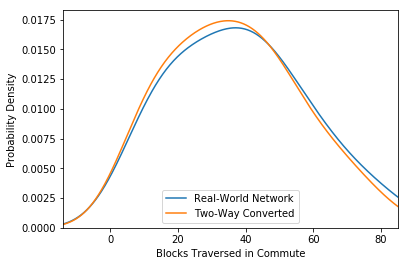

In [17]:
bw = 0.4
lw = 1.5
ax = (blocks_dir).plot.kde(label='Real-World Network', lw=lw, bw_method=bw)
ax = (blocks_undir).plot.kde(ax=ax, label='Two-Way Converted', lw=lw, bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-14, right=85)
ax.set_xlabel('Blocks Traversed in Commute')
ax.set_ylabel('Probability Density')
plt.legend()
plt.show()

In [18]:
# are the average blocks-traveled per trip significantly different?
a = blocks_dir
b = blocks_undir
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1119825, δ=1.65, t=60.97, p=0.0000


#### Second, look at metric distance (meters traveled)

In [19]:
%%time
# for the real-world directed graph
od_dir['network_distance_m'] = od_dir.apply(network_distance, axis=1, G_ig=G_dir_ig, nodeid_to_osmid=G_dir_nodeid_to_osmid, weight='length')

Wall time: 27min 21s


In [20]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_m'] = od_undir.apply(network_distance, axis=1, G_ig=G_undir_ig, nodeid_to_osmid=G_undir_nodeid_to_osmid, weight='length')

Wall time: 31min 56s


In [21]:
od_dir['network_distance_m'].describe()

count    1133334.000
mean             inf
std              NaN
min            0.000
25%         2763.252
50%         4724.975
75%         6862.442
max              inf
Name: network_distance_m, dtype: float64

In [22]:
od_undir['network_distance_m'].describe()

count    1133334.000
mean             inf
std              NaN
min            0.000
25%         2699.102
50%         4642.450
75%         6726.291
max              inf
Name: network_distance_m, dtype: float64

In [23]:
meters_dir = od_dir['network_distance_m'].replace([np.inf, -np.inf], np.nan).dropna()
meters_undir = od_undir['network_distance_m'].replace([np.inf, -np.inf], np.nan).dropna()

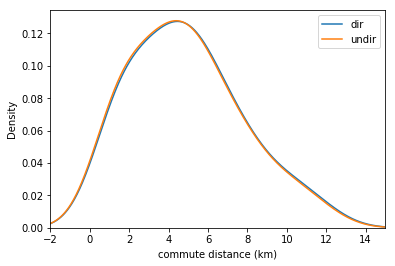

In [24]:
ax = (meters_dir/1000).plot.kde(label='dir', bw_method=bw)
ax = (meters_undir/1000).plot.kde(ax=ax, label='undir', bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-2, right=15)
ax.set_xlabel('commute distance (km)')
plt.legend()
plt.show()

## Stats

In [25]:
left = od_dir
right = od_undir[['network_distance_e', 'network_distance_m']]
df = pd.merge(left, right, left_index=True, right_index=True, suffixes=('_dir', '_undir'))
df.head()

,SAMPN,PERNO,orig,dest,network_distance_e_dir,network_distance_m_dir,network_distance_e_undir,network_distance_m_undir
0,1033944,1,65335448,65303721,80.0,10456.018,75.0,10252.679
1,1049908,1,65334137,1723738893,12.0,1586.707,12.0,1465.948
2,1051388,2,65298349,65303529,45.0,5382.936,42.0,5022.611
3,1051795,1,65294011,65352454,55.0,8897.233,53.0,8467.548
4,1069723,1,65301529,65329980,28.0,3880.537,28.0,3879.431


In [26]:
meters_dir = df['network_distance_m_dir'].replace([np.inf, -np.inf], np.nan).dropna()
meters_undir = df['network_distance_m_undir'].replace([np.inf, -np.inf], np.nan).dropna()

In [27]:
# are the average distances (m) traveled per trip significantly different?
a = meters_dir
b = meters_undir
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1119825, δ=66.53, t=17.45, p=0.0000


In [28]:
a.mean() / b.mean()

1.0136589625000592

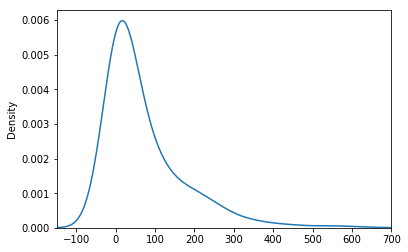

In [29]:
ax = (a - b).plot.kde(bw_method=bw)
ax.set_xlim(left=-150, right=700)
ax.set_ylim(bottom=0)
plt.show()

## Surplus VKT and fuel consumption

#### method 1

In [30]:
# daily km traveled in SF (trips entirely within SF only) https://www.sfcta.org/tncstoday
daily_km = 4586630

In [31]:
# estimate surplus VKT per day
surplus_vkt_daily = daily_km - (daily_km / (a.mean() / b.mean()))
surplus_vkt_daily

61804.42287722882

In [32]:
# estimate surplus VKT per year
surplus_vkt_daily * 365

22558614.35018852

#### method 2

In [33]:
total_daily_trips = 1133333 #how many trips begin and end in sf each day https://www.sfcta.org/tncstoday

In [34]:
# estimate surplus VKT per day
surplus_vkt_daily = total_daily_trips * (a.mean() - b.mean()) / 1000
surplus_vkt_daily

75397.2576336832

In [35]:
# estimate surplus VKT per year
surplus_vkt_daily * 365

27519999.036294367

#### fuel consumption

In [36]:
# how many surplus gallons of fuel does this waste per year?
fuel_econ = 39.75 # 23 mpg to km-p-g https://www.reuters.com/article/us-autos-emissions/u-s-vehicle-fuel-economy-rises-to-record-24-7-mpg-epa-idUSKBN1F02BX
surplus_fuel_gallons = (surplus_vkt_daily * 365) / fuel_econ
surplus_fuel_gallons

692327.0197809903

In [37]:
# burning a gallon of gas releases 20 lbs of CO2 https://www.fueleconomy.gov/feg/contentIncludes/co2_inc.htm
surplus_fuel_gallons * 20

13846540.395619806

## Save to disk

In [38]:
# save to disk
df.to_csv('data/od_distances-no-fwy-igraph.csv', index=False, encoding='utf-8')